### Employee Recommendations


This notebook is split into seven sections:

1. Data Prep & EDA
2. K-Means Clustering
3. PCA for Visualization
4. K-Means Clustering (Round 2)
5. PCA for Visualization (Round 2)
6. EDA on Clusters
7. Make Recommendations


**GOAL**: We are trying to better understand the company’s different segments of employees and how to increase employee retention within each segment.

**SCOPE**: We will use a clustering technique to segment the employees, a dimensionality reduction technique to visualize the segments, and finally explore the clusters to make recommendations to increase retention.


#### 1. Data Prep & EDA


In [71]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "../Data/employee_data.csv"
df_raw = pd.read_csv(file_path)
df_raw.head()


,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition
0,1001,41,Female,1,2,Sales,5993,3,4,Yes
1,1002,49,Male,8,2,Research & Development,5130,4,2,No
2,1004,37,Male,2,1,Research & Development,2090,3,3,Yes
3,1005,33,Female,3,1,Research & Development,2909,3,3,No
4,1007,27,Male,2,1,Research & Development,3468,3,2,No


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EmployeeID         1470 non-null   int64 
 1   Age                1470 non-null   int64 
 2   Gender             1470 non-null   object
 3   DistanceFromHome   1470 non-null   int64 
 4   JobLevel           1470 non-null   int64 
 5   Department         1470 non-null   object
 6   MonthlyIncome      1470 non-null   int64 
 7   PerformanceRating  1470 non-null   int64 
 8   JobSatisfaction    1470 non-null   int64 
 9   Attrition          1470 non-null   object
dtypes: int64(7), object(3)
memory usage: 115.0+ KB


#### a. Data Prep: Check the data types


In [6]:
df_raw.select_dtypes(include=["int", "float"]).columns

Index(['EmployeeID', 'Age', 'DistanceFromHome', 'JobLevel', 'MonthlyIncome',
       'PerformanceRating', 'JobSatisfaction'],
      dtype='object')

In [7]:
df_raw.select_dtypes(include=["object"]).columns

Index(['Gender', 'Department', 'Attrition'], dtype='object')

#### b. Data Prep: Converting the data types

Using `np.where` and `pd.get_dummies` to create a DataFrame for modeling where all fields are numeric.


In [12]:
df_raw["Gender"].value_counts()

Gender
Male      882
Female    588
Name: count, dtype: int64

In [9]:
df = df_raw.copy()
df["Gender"] = np.where(df["Gender"] == "Female", 1, 0)
df.head()


,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition
0,1001,41,1,1,2,Sales,5993,3,4,Yes
1,1002,49,0,8,2,Research & Development,5130,4,2,No
2,1004,37,0,2,1,Research & Development,2090,3,3,Yes
3,1005,33,1,3,1,Research & Development,2909,3,3,No
4,1007,27,0,2,1,Research & Development,3468,3,2,No


In [13]:
df["Attrition"].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [15]:
df["Attrition"] = np.where(df["Attrition"] == "Yes", 1, 0)

In [16]:
df["Department"].value_counts()

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

In [19]:
department_df = pd.get_dummies(df["Department"]).astype(int)

df_clean = pd.concat([df.drop("Department", axis=1), department_df], axis=1)
df_clean.head()


,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition,Human Resources,Research & Development,Sales
0,1001,41,1,1,2,5993,3,4,1,0,0,1
1,1002,49,0,8,2,5130,4,2,0,0,1,0
2,1004,37,0,2,1,2090,3,3,1,0,1,0
3,1005,33,1,3,1,2909,3,3,0,0,1,0
4,1007,27,0,2,1,3468,3,2,0,0,1,0


In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   EmployeeID              1470 non-null   int64
 1   Age                     1470 non-null   int64
 2   Gender                  1470 non-null   int32
 3   DistanceFromHome        1470 non-null   int64
 4   JobLevel                1470 non-null   int64
 5   MonthlyIncome           1470 non-null   int64
 6   PerformanceRating       1470 non-null   int64
 7   JobSatisfaction         1470 non-null   int64
 8   Attrition               1470 non-null   int32
 9   Human Resources         1470 non-null   int32
 10  Research & Development  1470 non-null   int32
 11  Sales                   1470 non-null   int32
dtypes: int32(5), int64(7)
memory usage: 109.2 KB


#### c. EDA

Our goal is to find the different types of employees at the company and take a look at their attrition (whether they end up leaving or not).


In [21]:
df_clean["Attrition"].mean()  # 16% of employees left the company

0.16122448979591836

In [22]:
# create a summary table to show the mean of each column for employees who stay vs leave the company

df_clean.groupby("Attrition").mean().T


Attrition,0,1
EmployeeID,2027.656123,2010.345992
Age,37.561233,33.607595
Gender,0.406326,0.367089
DistanceFromHome,8.915653,10.632911
JobLevel,2.145985,1.637131
MonthlyIncome,6832.739659,4787.092827
PerformanceRating,3.153285,3.156118
JobSatisfaction,2.778589,2.468354
Human Resources,0.041363,0.050633
Research & Development,0.671533,0.561181


**TAKEAWAYS:** People who stay (category 0) tend to be older, male, live closer by, more senior, have higher job satisfcation, work in R&D


#### d. Data Prep: Remove the Attrition and ID Columns

Exclude the attrition column (to be overlayed onto our clusters later on) and the ID column.


In [24]:
df_features = df_clean.drop(["Attrition", "EmployeeID"], axis=1)
df_features.head()


,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction,Human Resources,Research & Development,Sales
0,41,1,1,2,5993,3,4,0,0,1
1,49,0,8,2,5130,4,2,0,1,0
2,37,0,2,1,2090,3,3,0,1,0
3,33,1,3,1,2909,3,3,0,1,0
4,27,0,2,1,3468,3,2,0,1,0


In [25]:
df_features.shape

(1470, 10)

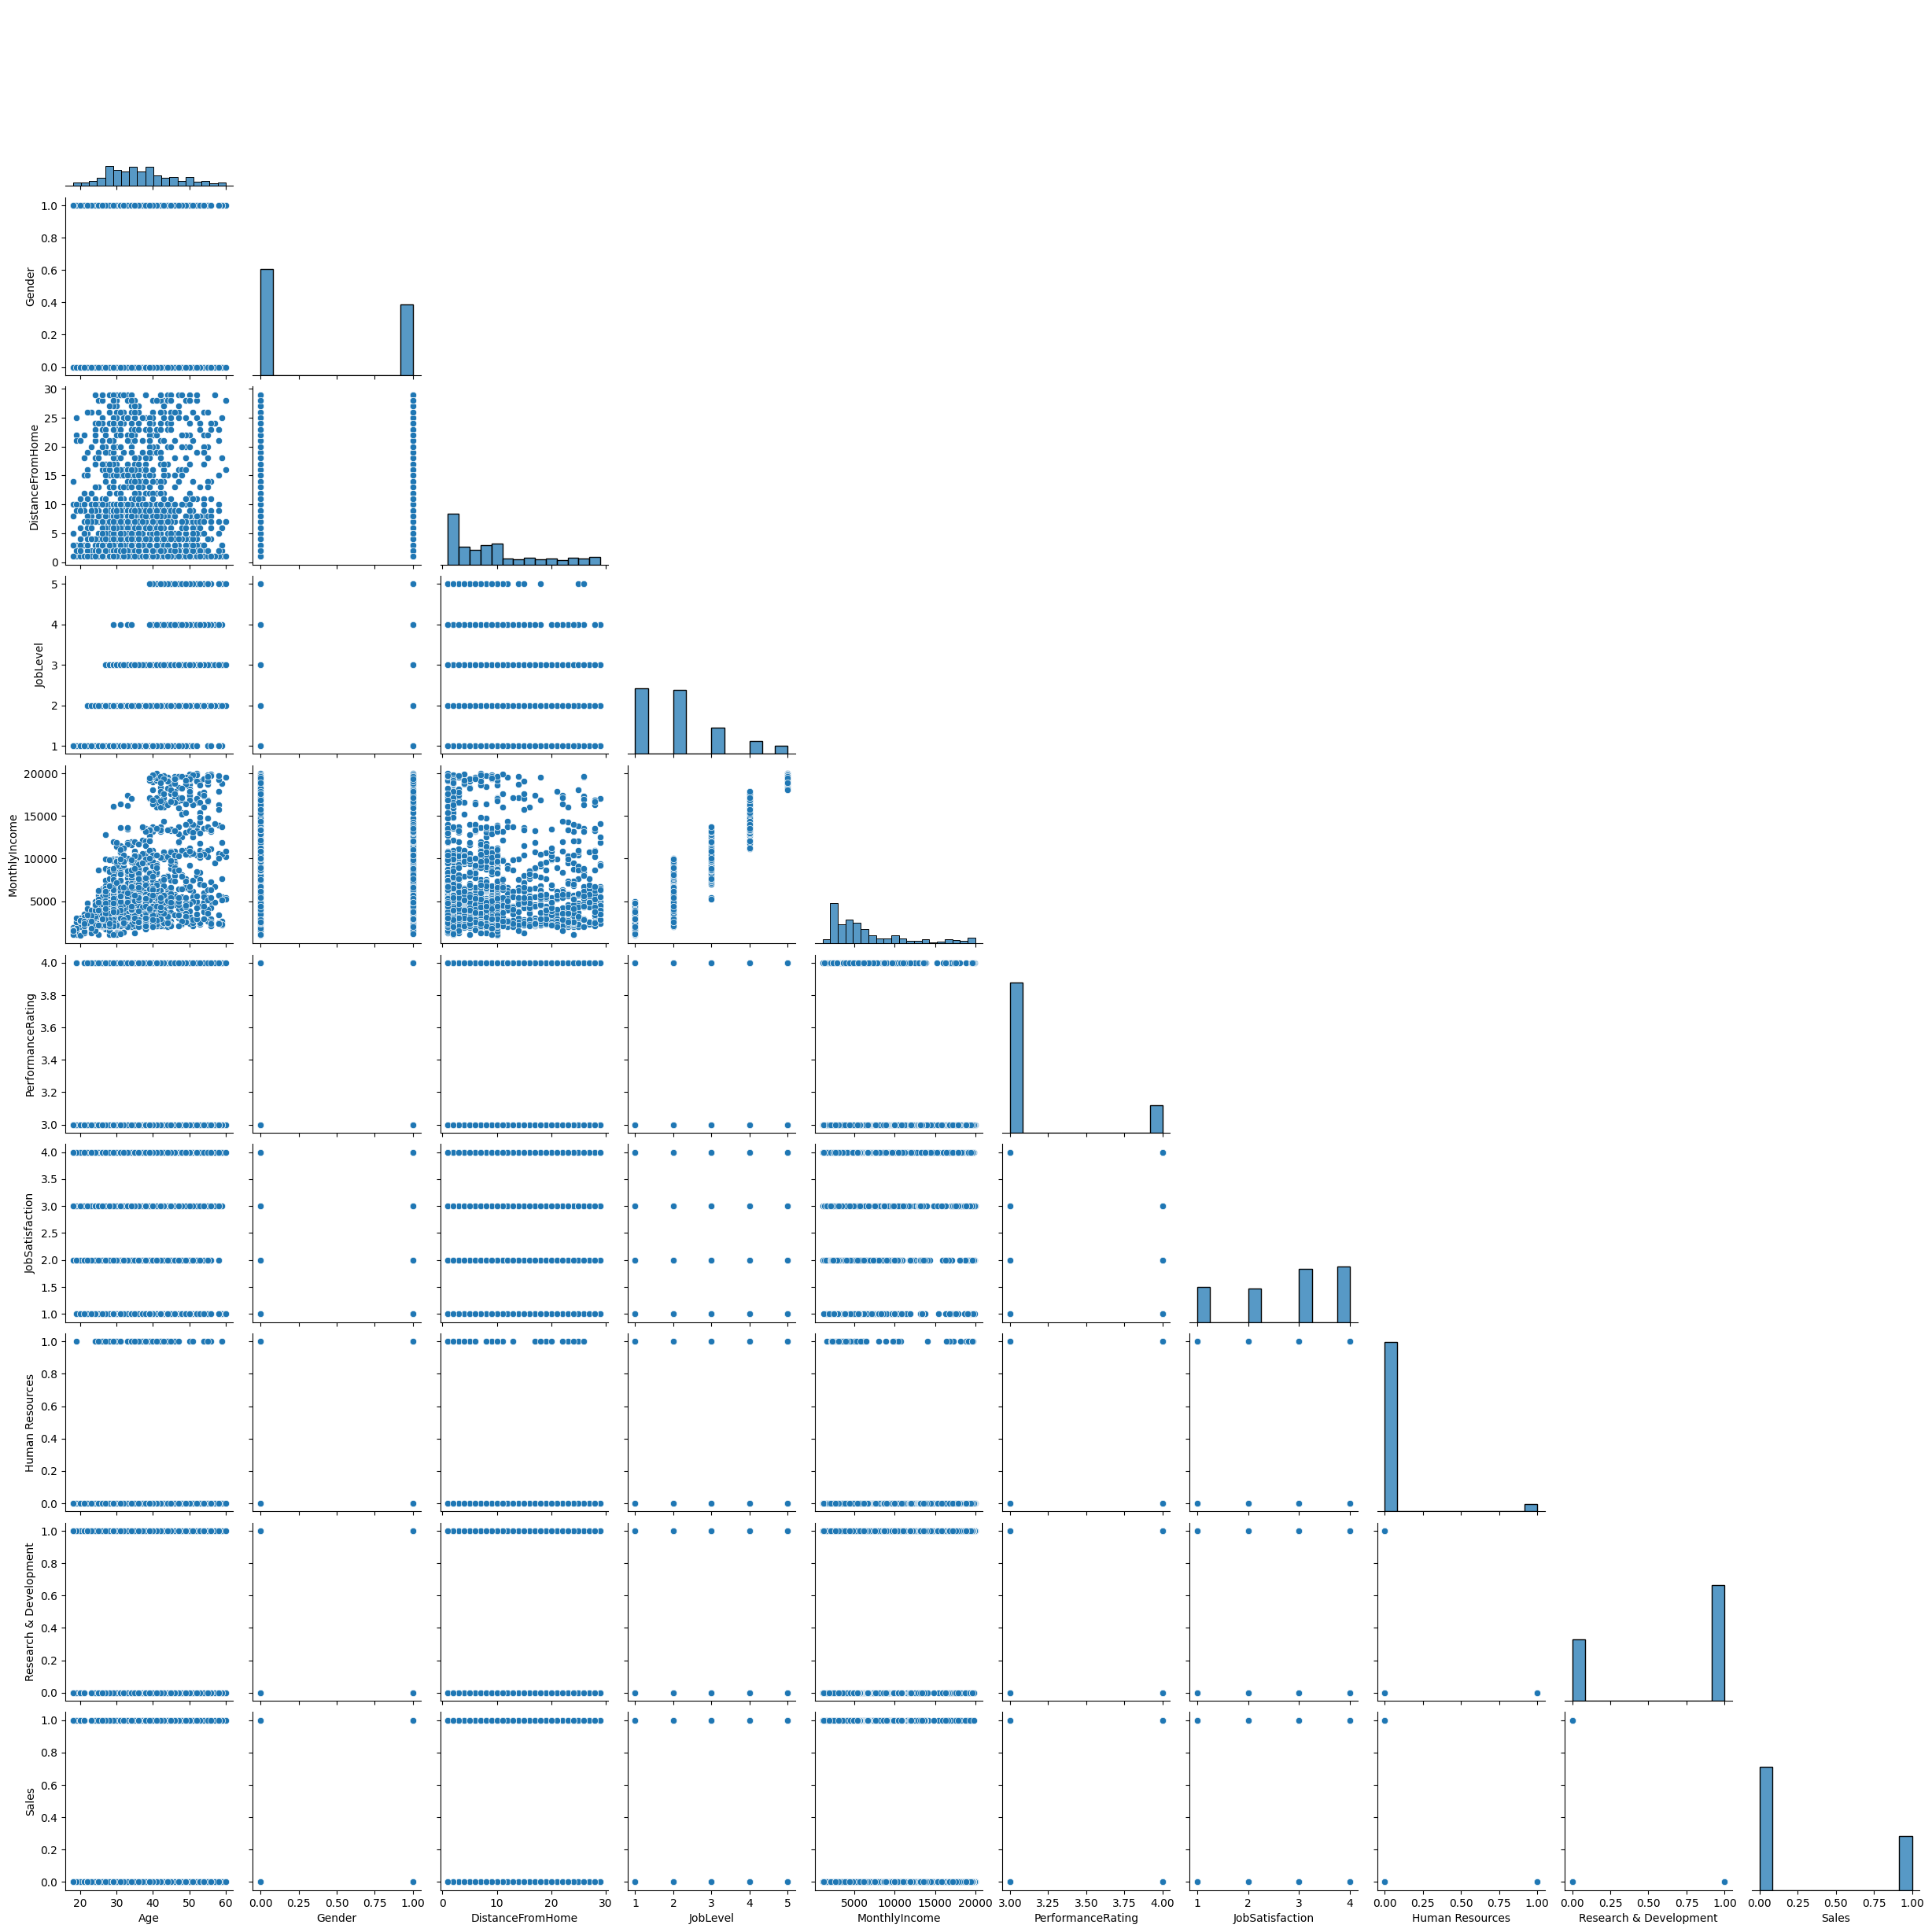

In [28]:
sns.pairplot(df_features, corner=True)

**OBSERVATIONS**:

- Age and gender seem to be pretty evenly distributed
- More people live closer to the office
- Job level and income are correlated
- There are fewer high performers
- Most people are happy with the jobs
- There are few people in HR compared to the other departments


### 2. K-Means Clustering

Let's segment the employees using K-Means clustering.


#### a. Standardize the data


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_scl = scaler.fit_transform(df_features)
features_scl = pd.DataFrame(features_scl, columns=df_features.columns)
features_scl.head()


,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction,Human Resources,Research & Development,Sales
0,0.446350,1.224745,-1.010909,-0.057788,-0.108350,-0.426230,1.153254,-0.211604,-1.374051,1.515244
1,1.322365,-0.816497,-0.147150,-0.057788,-0.291719,2.346151,-0.660853,-0.211604,0.727775,-0.659960
2,0.008343,-0.816497,-0.887515,-0.961486,-0.937654,-0.426230,0.246200,-0.211604,0.727775,-0.659960
3,-0.429664,1.224745,-0.764121,-0.961486,-0.763634,-0.426230,0.246200,-0.211604,0.727775,-0.659960
4,-1.086676,-0.816497,-0.887515,-0.961486,-0.644858,-0.426230,-0.660853,-0.211604,0.727775,-0.659960


In [31]:
features_scl.describe()

,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction,Human Resources,Research & Development,Sales
count,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03
mean,-3.504377e-17,-4.350262e-17,4.350262e-17,-2.658493e-17,-4.471102e-17,-6.114534e-16,-9.183886e-17,6.767074e-17,2.900174e-17,8.458842e-17
std,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00
min,-2.072192e+00,-8.164966e-01,-1.010909e+00,-9.614864e-01,-1.167343e+00,-4.262300e-01,-1.567907e+00,-2.116037e-01,-1.374051e+00,-6.599598e-01
25%,-7.581700e-01,-8.164966e-01,-8.875151e-01,-9.614864e-01,-7.632087e-01,-4.262300e-01,-6.608532e-01,-2.116037e-01,-1.374051e+00,-6.599598e-01
50%,-1.011589e-01,-8.164966e-01,-2.705440e-01,-5.778755e-02,-3.365516e-01,-4.262300e-01,2.462002e-01,-2.116037e-01,7.277751e-01,-6.599598e-01
75%,6.653541e-01,1.224745e+00,5.932157e-01,8.459113e-01,3.986245e-01,-4.262300e-01,1.153254e+00,-2.116037e-01,7.277751e-01,1.515244e+00
max,2.526886e+00,1.224745e+00,2.444129e+00,2.653309e+00,2.867626e+00,2.346151e+00,1.153254e+00,4.725816e+00,7.277751e-01,1.515244e+00


#### b. Loop to fit models with 2 to 15 clusters and record the inertia and silhouette scores


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_vals = range(2, 16)
inerta_vals = []
silhouette_vals = []

for k in k_vals:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features_scl)
    inerta_vals.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(features_scl, kmeans.labels_))


In [37]:
# plot the inertia values and silhouette_scores in subplots
from plotly.subplots import make_subplots

fig1 = px.line(x=k_vals, y=inerta_vals, labels={"x": "k", "y": "Inertia"})

fig2 = px.line(x=k_vals, y=silhouette_vals, labels={"x": "k", "y": "Silhouette Score"})

fig = make_subplots(
    rows=2, cols=1, subplot_titles=("Inertia vs k", "Silhouette Score vs k")
)

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

fig.show()


#### c. _For k = 4_ the inertia plot like an elbow on the inertia plot and has a high silhouette score, thus we choose to model with k = 4 segments


In [38]:
km4 = KMeans(n_clusters=4, n_init=10, random_state=42)
km4.fit(features_scl)


KMeans(n_clusters=4, n_init=10, random_state=42)

In [39]:
labels_df = pd.DataFrame(km4.labels_, columns=["Cluster"])
labels_df["Cluster"].value_counts()


Cluster
0    747
1    407
2    253
3     63
Name: count, dtype: int64

<Axes: >

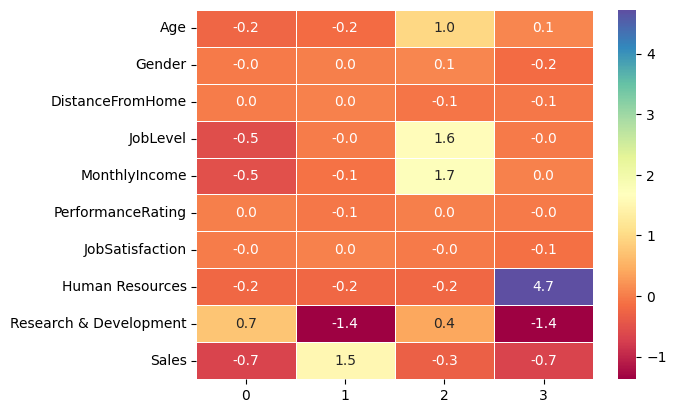

In [53]:
cluster_centers_df = pd.DataFrame(km4.cluster_centers_, columns=features_scl.columns)

sns.heatmap(
    cluster_centers_df.T, annot=True, cmap="Spectral", fmt=".1f", linewidths=0.5
)


Interpret the clusters:

- Cluster 0: junior, research & dev employees
- Cluster 1: sales employees
- Cluster 2: senior employees
- Cluster 3: HR employees


### 3. PCA

Let's visualize the data using PCA.

#### a. Fit a PCA Model with 2 components for visualization


In [54]:
from sklearn.decomposition import PCA

pc2 = PCA(n_components=2).fit(features_scl)
pc2.explained_variance_ratio_


array([0.23793893, 0.18883434])

In [57]:
# use full width to print the components for np array
np.set_printoptions(linewidth=np.inf)
pc2.components_


array([[ 0.43287352,  0.04877625, -0.00285089,  0.60509274,  0.59445012, -0.02556521, -0.00472736,  0.02964393, -0.21392918,  0.20833797],
       [-0.21384802,  0.00840873,  0.01653328, -0.14533326, -0.17730123, -0.04153184,  0.01140416,  0.11374447, -0.67887246,  0.65246219]])

In [58]:
# view the columns
features_scl.columns


Index(['Age', 'Gender', 'DistanceFromHome', 'JobLevel', 'MonthlyIncome',
       'PerformanceRating', 'JobSatisfaction', 'Human Resources',
       'Research & Development', 'Sales'],
      dtype='object')

Interpret the components:

- Component 1: higher age, job level, monthly income = more senior
- Component 2: lower = research, higher = sales


### b. Overlaying the K-Means cluster colors


In [60]:
pc2_df = pd.DataFrame(pc2.transform(features_scl), columns=["PC1", "PC2"])
pc2_df["Cluster"] = km4.labels_
pc2_df.head()


,PC1,PC2,Cluster
0,0.765263,1.853973,1
1,-0.031684,-1.285674,0
2,-1.462588,-0.645564,0
3,-1.449531,-0.563547,0
4,-1.758252,-0.473654,0


<Axes: xlabel='PC1', ylabel='PC2'>

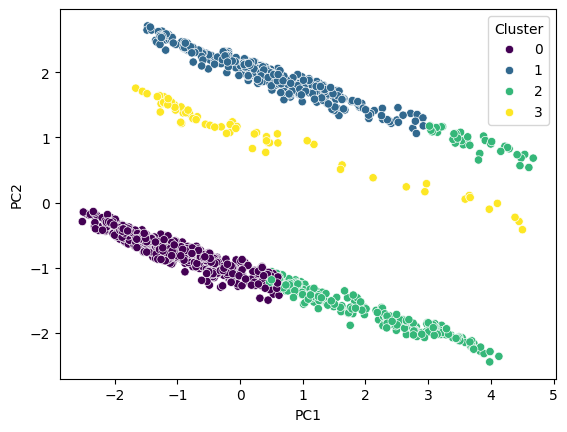

In [61]:
sns.scatterplot(data=pc2_df, x="PC1", y="PC2", hue="Cluster", palette="viridis")

### c. Overlaying the Department colors instead since there is some overlap in the above figure


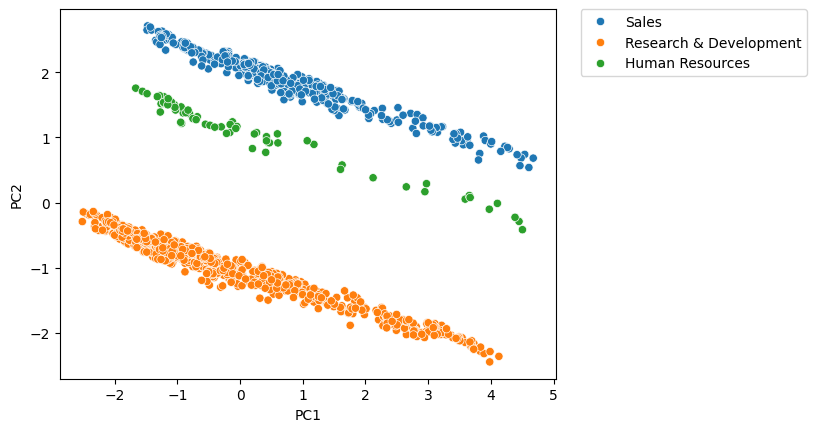

In [76]:
sns.scatterplot(pc2_df, x="PC1", y="PC2", hue=df["Department"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


### 4. K-Means Clustering: Round 2

Since the departments seemed to dominate the visualization, let's exclude them and try fitting more K-Means models.

#### a. Create a new dataframe without the Departments


In [77]:
features_scl.columns

Index(['Age', 'Gender', 'DistanceFromHome', 'JobLevel', 'MonthlyIncome',
       'PerformanceRating', 'JobSatisfaction', 'Human Resources',
       'Research & Development', 'Sales'],
      dtype='object')

In [83]:
features_scl_v2 = features_scl.drop(
    ["Human Resources", "Research & Development", "Sales"], axis=1
)

features_scl_v2.head()


,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction
0,0.446350,1.224745,-1.010909,-0.057788,-0.108350,-0.426230,1.153254
1,1.322365,-0.816497,-0.147150,-0.057788,-0.291719,2.346151,-0.660853
2,0.008343,-0.816497,-0.887515,-0.961486,-0.937654,-0.426230,0.246200
3,-0.429664,1.224745,-0.764121,-0.961486,-0.763634,-0.426230,0.246200
4,-1.086676,-0.816497,-0.887515,-0.961486,-0.644858,-0.426230,-0.660853


#### b. Loop to fit models with 2 to 15 clusters and record the inertia and silhouette scores


In [84]:
k_vals = range(2, 16)
inerta_vals = []
silhouette_vals = []

for k in k_vals:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features_scl_v2)
    inerta_vals.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(features_scl_v2, kmeans.labels_))


In [86]:
# plot the inertia values and silhouette_scores in subplots
from plotly.subplots import make_subplots

fig1 = px.line(x=k_vals, y=inerta_vals, labels={"x": "k", "y": "Inertia"})
fig2 = px.line(x=k_vals, y=silhouette_vals, labels={"x": "k", "y": "Silhouette Score"})

fig = make_subplots(
    rows=2, cols=1, subplot_titles=("Inertia vs k", "Silhouette Score vs k")
)

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

fig.show()


#### c. Lets use few k values that looks like an elbow on the inertia plot and have a high silhouette score

#### i. k=3


In [87]:
km3_v2 = KMeans(n_clusters=3, n_init=10, random_state=42)
km3_v2.fit(features_scl_v2)


KMeans(n_clusters=3, n_init=10, random_state=42)

In [88]:
pd.Series(km3_v2.labels_).value_counts()

1    988
2    282
0    200
Name: count, dtype: int64

<Axes: >

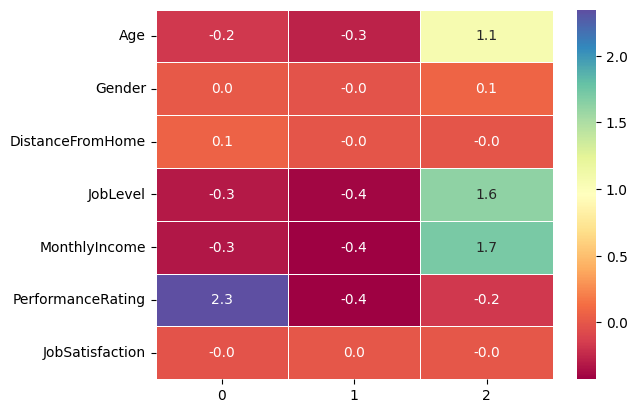

In [89]:
cluster_centers_df_v2 = pd.DataFrame(
    km3_v2.cluster_centers_, columns=features_scl_v2.columns
)

sns.heatmap(
    cluster_centers_df_v2.T, annot=True, cmap="Spectral", fmt=".1f", linewidths=0.5
)


Interpret the clusters:

- Cluster 0: high performing employees
- Cluster 1: junior, low performing employees
- Cluster 2: senior employees


#### ii. k=4


In [90]:
km4_v2 = KMeans(n_clusters=4, n_init=10, random_state=42)
km4_v2.fit(features_scl_v2)


KMeans(n_clusters=4, n_init=10, random_state=42)

In [91]:
pd.Series(km4_v2.labels_).value_counts()

2    616
0    405
1    249
3    200
Name: count, dtype: int64

<Axes: >

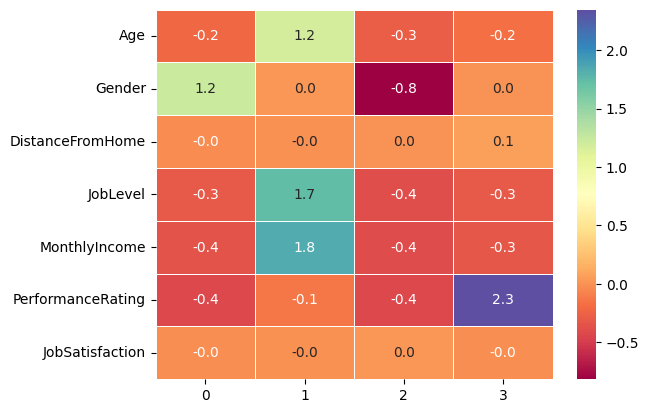

In [92]:
cluster_centers_df_v2 = pd.DataFrame(
    km4_v2.cluster_centers_, columns=features_scl_v2.columns
)


sns.heatmap(
    cluster_centers_df_v2.T, annot=True, cmap="Spectral", fmt=".1f", linewidths=0.5
)


Interpret the clusters:

- Cluster 0: female employees
- Cluster 1: senior employees
- Cluster 2: male employees
- Cluster 3: high performing employees


#### iii. k=6


In [95]:
km6_v2 = KMeans(n_clusters=6, n_init=10, random_state=42)
km6_v2.fit(features_scl_v2)


KMeans(n_clusters=6, n_init=10, random_state=42)

In [96]:
pd.Series(km6_v2.labels_).value_counts()

3    349
0    304
4    219
5    201
1    200
2    197
Name: count, dtype: int64

<Axes: >

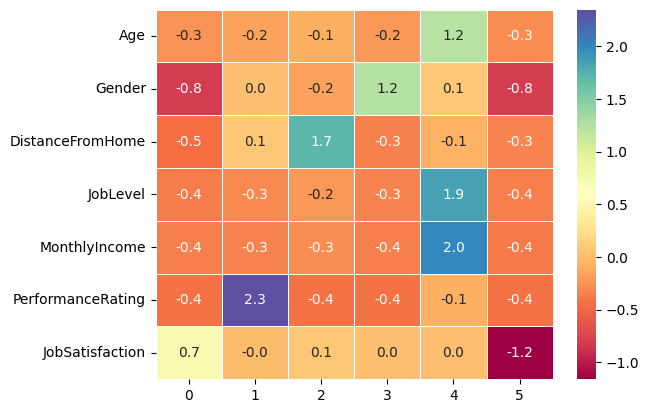

In [97]:
cluster_centers_df_v2 = pd.DataFrame(
    km6_v2.cluster_centers_, columns=features_scl_v2.columns
)


sns.heatmap(
    cluster_centers_df_v2.T, annot=True, cmap="Spectral", fmt=".1f", linewidths=0.5
)


Interpret the clusters:

- Cluster 0: men who like their jobs
- Cluster 1: high performers
- Cluster 2: long commuters
- Cluster 3: women
- Cluster 4: senior employee
- Cluster 5: men who dislike their jobs


### 5. PCA: Round 2

Let's visualize the data (without Departments) using PCA.

#### a. Fit a PCA Model with 2 components for visualization


In [98]:
pc2_v2 = PCA(n_components=2).fit(features_scl_v2)
pc2_v2.explained_variance_ratio_


array([0.33354222, 0.14850324])

In [100]:
pc2_v2.components_

array([[ 0.47124275,  0.0460627 , -0.00629691,  0.62393147,  0.62140377, -0.01687984, -0.00712661],
       [ 0.01896906,  0.58615904,  0.41405416, -0.01838822, -0.02778096,  0.4833175 , -0.49991119]])

In [101]:
# view the columns
features_scl_v2.columns


Index(['Age', 'Gender', 'DistanceFromHome', 'JobLevel', 'MonthlyIncome',
       'PerformanceRating', 'JobSatisfaction'],
      dtype='object')

Interpret the components:

- Component 1: higher age, job level, monthly income = more senior
- Component 2: <-- happy in job | women, longer commute, higher perfomring -->


#### b. Overlay the K-Means cluster colors


<Axes: xlabel='PC1', ylabel='PC2'>

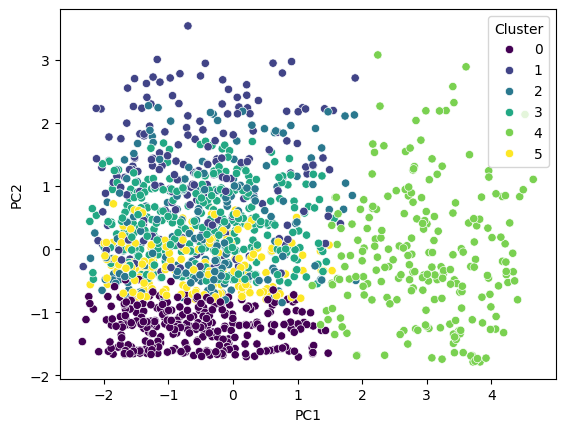

In [106]:
pc2_df_v2 = pd.DataFrame(pc2_v2.transform(features_scl_v2), columns=["PC1", "PC2"])
pc2_df_v2["Cluster"] = km6_v2.labels_

sns.scatterplot(data=pc2_df_v2, x="PC1", y="PC2", hue="Cluster", palette="viridis")


### 6. EDA on Clusters


We go with the 6 clusters without department data.


In [107]:
# view the cluster labels
km6_v2.labels_


array([3, 1, 0, ..., 1, 5, 0])

#### a. Create a dataframe with the cluster labels and names


In [108]:
clusters = pd.DataFrame(km6_v2.labels_, columns=["Cluster"])
clusters.head()


,Cluster
0,3
1,1
2,0
3,3
4,5


In [109]:
# create a mapping for the cluster names
cluster_mapping = {
    0: "Men who like their jobs",
    1: "High performers",
    2: "Long commuters",
    3: "Female employees",
    4: "Senior employees",
    5: "Men who dislike their jobs",
}


In [110]:
clusters["Cluster"] = clusters["Cluster"].map(cluster_mapping)
clusters.head()


,Cluster
0,Female employees
1,High performers
2,Men who like their jobs
3,Female employees
4,Men who dislike their jobs


#### c. View the attrition rates for each cluster


In [111]:
# combine the clusters and attrition data
clusters["Attrition"] = df["Attrition"]
clusters.head()


,Cluster,Attrition
0,Female employees,1
1,High performers,0
2,Men who like their jobs,1
3,Female employees,0
4,Men who dislike their jobs,0


In [115]:
# attrition rate for each cluster
cluster_attr = clusters.groupby("Cluster")["Attrition"].mean()
cluster_attr


Cluster
Female employees              0.154728
High performers               0.185000
Long commuters                0.218274
Men who dislike their jobs    0.189055
Men who like their jobs       0.161184
Senior employees              0.073059
Name: Attrition, dtype: float64

In [116]:
# sort the values
cluster_attr = cluster_attr.sort_values(ascending=False)
cluster_attr


Cluster
Long commuters                0.218274
Men who dislike their jobs    0.189055
High performers               0.185000
Men who like their jobs       0.161184
Female employees              0.154728
Senior employees              0.073059
Name: Attrition, dtype: float64

Interpret the findings:

- Long commuters are most likely to leave
- Senior employees are most likely to stay


In [119]:
# number of employees in each cluster
clusters.groupby("Cluster").count()


,Attrition
Cluster,
Female employees,349
High performers,200
Long commuters,197
Men who dislike their jobs,201
Men who like their jobs,304
Senior employees,219


#### d. View the department breakdown for each cluster


In [120]:
# combine the clusters and department data
clusters["Department"] = df["Department"]
clusters.head()


,Cluster,Attrition,Department
0,Female employees,1,Sales
1,High performers,0,Research & Development
2,Men who like their jobs,1,Research & Development
3,Female employees,0,Research & Development
4,Men who dislike their jobs,0,Research & Development


In [121]:
# attrition rate for each cluster + department combination
cluster_dept_attr = clusters.groupby(["Cluster", "Department"])["Attrition"].mean()
cluster_dept_attr


Cluster                     Department            
Female employees            Human Resources           0.300000
                            Research & Development    0.121076
                            Sales                     0.206897
High performers             Human Resources           0.142857
                            Research & Development    0.188406
                            Sales                     0.181818
Long commuters              Human Resources           0.666667
                            Research & Development    0.153846
                            Sales                     0.311475
Men who dislike their jobs  Human Resources           0.214286
                            Research & Development    0.172131
                            Sales                     0.215385
Men who like their jobs     Human Resources           0.071429
                            Research & Development    0.152284
                            Sales                     0.193548
Seni

In [122]:
# sort the values
cluster_dept_attr.sort_values(ascending=False)


Cluster                     Department            
Long commuters              Human Resources           0.666667
                            Sales                     0.311475
Female employees            Human Resources           0.300000
Men who dislike their jobs  Sales                     0.215385
                            Human Resources           0.214286
Female employees            Sales                     0.206897
Men who like their jobs     Sales                     0.193548
High performers             Research & Development    0.188406
                            Sales                     0.181818
Men who dislike their jobs  Research & Development    0.172131
Long commuters              Research & Development    0.153846
Men who like their jobs     Research & Development    0.152284
High performers             Human Resources           0.142857
Senior employees            Sales                     0.125000
Female employees            Research & Development    0.121076
Men 

Interpret the findings:

- The groups most likely to leave are people with long commutes, women in HR and those in HR and sales
- The groups most likely NOT to leave are senior employees, men who like their jobs and those in research and development


In [126]:
# number of employees in each cluster + department combo

clusters.groupby(["Cluster", "Department"]).count().sort_values(
    by="Attrition", ascending=False
).rename(columns={"Attrition": "Count"})


,,Count
Cluster,Department,
Female employees,Research & Development,223
Men who like their jobs,Research & Development,197
Senior employees,Research & Development,151
High performers,Research & Development,138
Long commuters,Research & Development,130
Men who dislike their jobs,Research & Development,122
Female employees,Sales,116
Men who like their jobs,Sales,93
Men who dislike their jobs,Sales,65


### 7. Make Recommendations

In [130]:
cluster_dept_attr.sort_values(ascending=False)

Cluster                     Department            
Long commuters              Human Resources           0.666667
                            Sales                     0.311475
Female employees            Human Resources           0.300000
Men who dislike their jobs  Sales                     0.215385
                            Human Resources           0.214286
Female employees            Sales                     0.206897
Men who like their jobs     Sales                     0.193548
High performers             Research & Development    0.188406
                            Sales                     0.181818
Men who dislike their jobs  Research & Development    0.172131
Long commuters              Research & Development    0.153846
Men who like their jobs     Research & Development    0.152284
High performers             Human Resources           0.142857
Senior employees            Sales                     0.125000
Female employees            Research & Development    0.121076
Men 

#### Recommendations to retain employees in each cluster

Higher attrition:
* Long commuters: find remote options
* Female employees: create a more inclusive remote culture
* Men who dislike their jobs: have their managers have conversations with them
* Higher performers: find opportunities for more senior positions

Lower attrition:

* Senior employees: this makes sense that they have less attrition since they've been around a long time
* Female employees: this is an interesting finding, dig more into why this is the case
* Men who like their jobs: this make sense that people who like their job would stay